# 1D, 2D, and 3D Track Reconstruction

The goal of these sessions is to eventually get to the point where we have 3d track reconstruction. The roadmap to get to that point will involve some image processing of both the ITO and the camera image. Once these have been properly prepared, we can then reconstruct our track, both in a voxelized way and using a ridgefinding algorithm.

In [ ]:
### First, we have to import the required libraries ###
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage import io
import os
import sys
from astropy.io import fits
import pandas as pd
from scipy import interpolate

In [ ]:
! git clone https://github.com/tillyeg01/Migdal_Workshop_2022.git
! git pull

Cloning into 'Migdal_Workshop_2022'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.
fatal: not a git repository (or any of the parent directories): .git


##ITO

In [ ]:
## First we'll grab the ITO image that we've precreated. 
ITO = np.load('/content/Migdal_Workshop_2022/ITO_Event_MW2022.npy').T

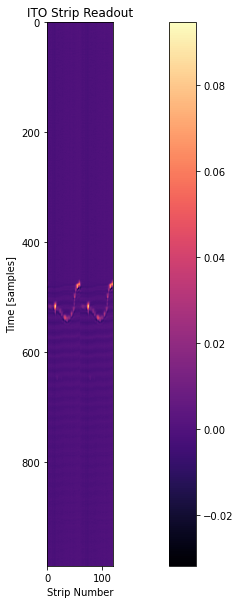

In [ ]:
## Here we actually plot the ITO 'image'
fig,(ax1) = plt.subplots(1,1,figsize=(20,10))
i1 = ax1.imshow(ITO,cmap='magma')
ax1.set_title("ITO Strip Readout")
ax1.set_ylabel('Time [samples]')
ax1.set_xlabel("Strip Number")
fig.colorbar(i1)

plt.show()


Zooming in:

Text(0.5, 1.0, 'ITO strip readout')

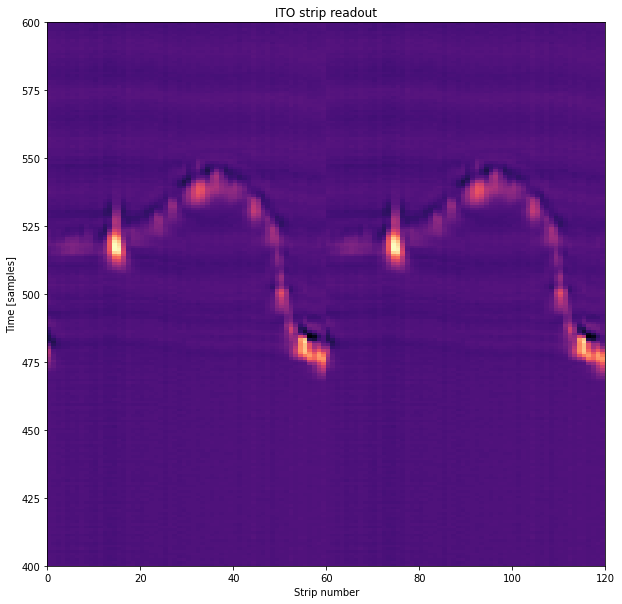

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(ITO, cmap='magma')
ax.set_ylim(400,600)
ax.set_xlim(0,120)
ax.set_ylabel("Time [samples]")
ax.set_xlabel("Strip number")
ax.set_title("ITO strip readout")

You'll notice that in this image, the track is doubled. This is because each ITO strip (i) is connected to the (60+i) strip.  
In order to use this in voxelized track reconstruction, we'll now need to mask the track. 

In [ ]:
ito_med = np.median(ITO) #Find the median of the ITO image
ito_sig = np.std(ITO) #Find the standard deviation of the ITO image
threshp = ito_med+0.9*ito_sig #This is our mask threshold

from skimage import morphology
ITOmask = ITO >= threshp #Create the mask
ITOmask = morphology.remove_small_objects(ITOmask, 20) #If there are 'objects' within the mask smaller than #, reject them
ITOmask = morphology.remove_small_holes(ITOmask, 40) #If there are 'holes' within objects in the mask smaller than #, fill them in

ITOtrack=ITO*ITOmask #Mask the original image

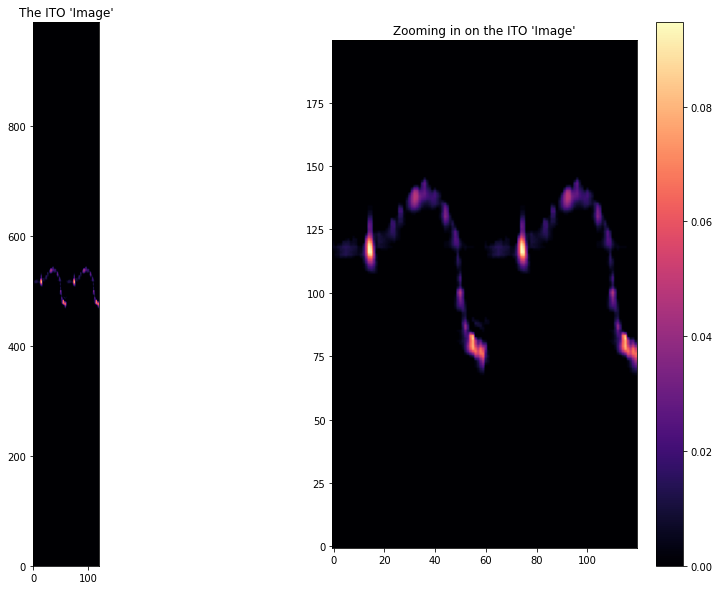

In [ ]:
## Check the new masked image
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
i1=ax1.imshow(ITOtrack,cmap='magma',origin='lower')
ax1.set_title("The ITO 'Image'")
fig.colorbar(i1)

## Zoom in a bit on the actual track
ax2.imshow(ITOtrack[400:600],cmap='magma',origin='lower')
ax2.set_title("Zooming in on the ITO 'Image'")
plt.show()

If we intend to investigate the charge deposited on each strip then we need to integrate over each one, but need to do some cleanup first.

Integration of ITO pulses:
    Can be done multiple ways, but this looks for the peak of the pulse and finds the points before and after where the signal passes through zero, then sums the points between the start and end.
    
Before doing this, it finds the mean (based on the first 200 samples) and removes the DC offset. It also finds the standard deviation.

Text(0, 0.5, 'Charge deposited to strip [Au]')

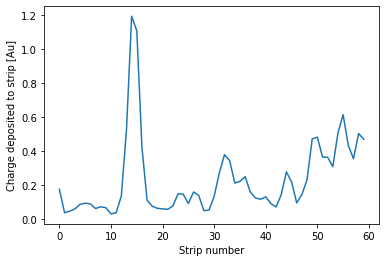

In [ ]:
def stripintegrals(eventdata):
        """
        Inputs
        --------
        eventdata: 3d numpy array, indexing - 1st specifies the strip and 2nd the sample number
        
        Outputs:
        ---------
        rowintegrals: returns the energy deposition on each strip, as a numpy array
        """
        rowintegrals = np.zeros(60)
        
        for i in range(60):
            rowdata = eventdata[i]
            offsetmean = np.mean(rowdata[:200])
            std = np.std(rowdata[:200])
            rowdata = np.subtract(rowdata, offsetmean)
            max = np.amax(rowdata)
            maxindex = int(np.where(rowdata == max)[0][0])
            
            #finds the points at which the signal drops below zero
            startfound = False
            j = maxindex
            
            while ((startfound == False) and (j >= 0)):
                if rowdata[j] <= 0:
                    startpoint = j
                    startfound = True
                else:
                    j -= 1
              
            endfound = False
            k = maxindex
            while ((endfound == False) and (k<1000)):
                if rowdata[k] <= 0:
                    endpoint = k
                    endfound = True
                else:
                    k += 1
              
            if (max > 5*std):
                integral = np.sum(rowdata[startpoint:endpoint])
                rowintegrals[i] = integral
            else:
                rowintegrals[i] = 0
            
        return(rowintegrals)

eventdata = ITO.T[:60]
charge = stripintegrals(eventdata)
plt.plot(charge)
plt.xlabel("Strip number")
plt.ylabel("Charge deposited to strip [Au]")

And the total charge deposited during the event:

In [ ]:
eventcharge = np.sum(charge)
print("Charge deposited in event: "+str(eventcharge)+ " au")

Charge deposited in event: 13.9495387125 au


## Image

Now we'll do a very similar process with the corresponding camera images. It was split by the rolling shutter, so we'll have to combine the two images which contain it. These particular images have already had some image processing done to them.

In [ ]:
## Import our camera images
Image1 = img = np.array(fits.getdata('/content/Migdal_Workshop_2022/MIG_Fe55_data_220803T152221.CAL.3851 FFT.fits'))
Image2 =  np.array(fits.getdata('/content/Migdal_Workshop_2022/MIG_Fe55_data_220803T152221.CAL.3852 FFT.fits'))

Text(0.5, 1.0, 'Image 2')

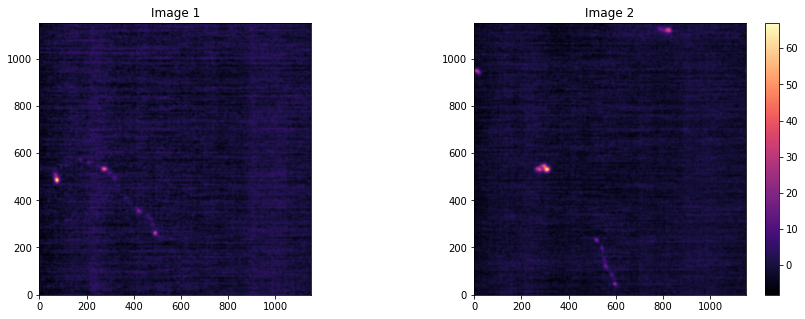

In [ ]:
## Let's take a look at what we're working with.
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
i1=ax1.imshow(Image1,cmap='magma',origin='lower')
fig.colorbar(i1)
ax1.set_title("Image 1")
ax2.imshow(Image2,cmap='magma',origin='lower')
ax2.set_title("Image 2")

Something cool to see here is that there are a bunch Fe-55 within the second image that could be investigated as well. These will, however, make masking our track a little bit more tricky than in the ITO image. 

In [ ]:
## Image 1 ##
Im1_med = np.median(Image1) #Find the median of Image1
Im1_std = np.std(Image1) #Find the standard deviation of Image1
thresh1 = Im1_med+0.9*Im1_std #This is the mask threshold for our first image

Im1Mask = Image1 >= thresh1 #Create the Mask
Im1Track=Image1*Im1Mask #Mask the Image

## Image 2 ##

Im2_med = np.median(Image2) #Find the median of Image1
Im2_std = np.std(Image2) #Find the standard deviation of Image1
thresh2 = Im2_med+1.8*Im2_std #This is the mask threshold for our first image

Im2Mask = Image2 >= thresh2 #Create the Mask
Im2Track=Image2*Im2Mask #Mask the Image

Text(0.5, 1.0, 'Image 2')

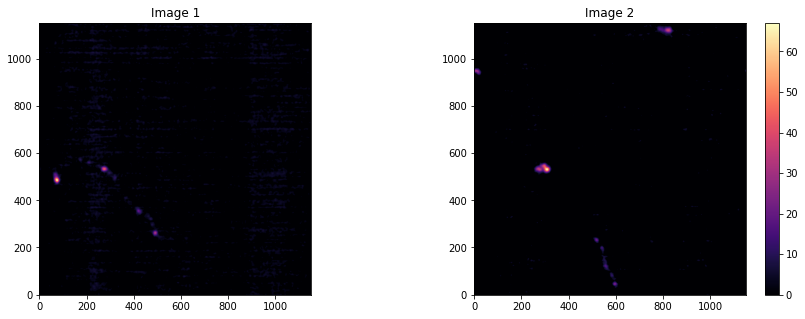

In [ ]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
i1=ax1.imshow(Im1Track,cmap='magma',origin='lower')
fig.colorbar(i1)

ax1.set_title("Image 1")
ax2.imshow(Im2Track,cmap='magma',origin='lower')
ax2.set_title("Image 2")

Now, we have to get rid of the extra Fe-55 tracks. Fortunately, all of them lie above ~300 pix on image 2, so it'll be pretty easy to remove them. Unfortunately, there is a substantial amount of noise in the first image that cannot be cut out without removing pieces of the track.

Text(0.5, 1.0, 'Image 2')

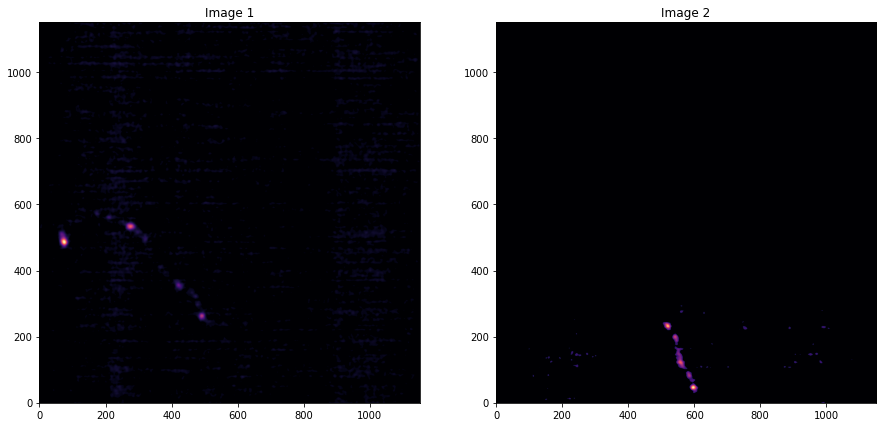

In [ ]:
Im2Track[300:]=0 ## Remove the pixels above 300
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,15))
ax1.imshow(Im1Track,cmap='magma',origin='lower')
ax1.set_title("Image 1")
ax2.imshow(Im2Track,cmap='magma',origin='lower')
ax2.set_title("Image 2")

Now, we're ready to combine these two images. 

Text(0.5, 1.0, 'Combined Image')

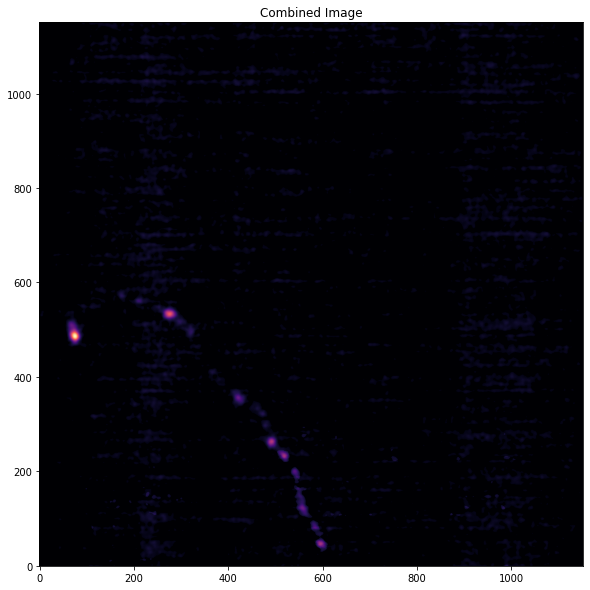

In [ ]:
Image = Im1Track+Im2Track

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(Image,cmap='magma',origin='lower')
ax.set_title("Combined Image")

#### Using the Ridgefinder


The Ridgefinding algorithm was first developed by Carsten Steger in the following paper: 

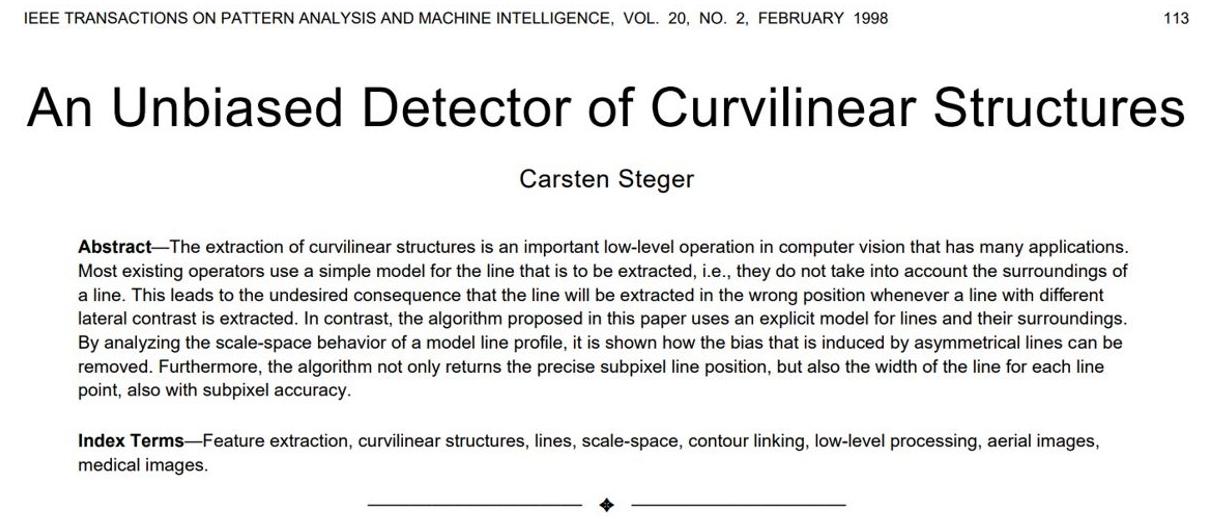

In short, it takes and image with tracks/lines and finds its first and second spacial derivatives. With these derivatives, it creates a Hessian matrix at every pixel. The eigenvalues of these matrices correspond to locations of "ridges" in the image. In our case, these ridges correspond to tracks and can be used in track reconstruction. 

As an example, here's an Fe-55 simulated track with a ridgeline fit to it:

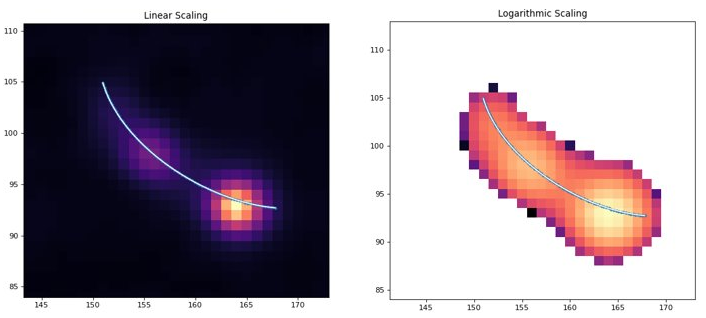

Some parameters that you will need to find a good ridge using the ridgefinder are as follows:

**Sigma**: *float*: sigma for derivative determination ~> Supposedly related to track width  
*This determines how much the algorightm needs to smooth the image to find the track*   

**lthresh**: *float*: tracks with a response lower than this are rejected (0 accepts all)  
*This helps to get rid of the ridges found in the noise*  

**uthresh**: *float*: tracks with a response higher than this are rejected (0 accepts all)  
*Sometimes, the background exhibit very strong patterns which the ridgefinder will pickup on. This parameter can be used to mitigate that.* 

**minlen**: *int*:  minimum track length accepted  
*This is handy in rejecting ridges found in the noise*

**linkthresh**: *int*: maximum distance to link ridges (in the case that there are multiple ridgelines on a given track)  
*Ridgelines have a tendency of being broken up along the length of a track. This helps to connect them. However, if many tracks are near one another, this can also link them, so a balance has to be found.*

**logim**: *Boolean*: which allows you to analyse an image in linear space (False) or log space (True)  
*Sometimes, it is easier to extract ridgelines by log filtering the image.*

In [ ]:
!pip install requests
import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/tillyeg01/Simplified_RidgeFinder/main/RFFunctions.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('RFFunctions.py', 'w') as f:
    f.write(r.text)

# now we can import
import RFFunctions as RF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



For now, we will use the function below to explore using the ridgefinder. If you're interested, feel free to look through it, but it's not essential right now. The meat of the ridgefinder is found in the file imported above, but implementing it is relatively straightforward. 

In [ ]:
def get_ridge(img,sigma, lthresh, uthresh, minlen, linkthresh, logim = False):
    '''
    Create a figure containing the image of the particle track and its
    ridgeline. Two plots are produced in this figure. One is in linear space
    and the other is in log space. On both, the unlinked and linked ridges are
    plotted. The linked are plotted as a thin white line overlayed on the 
    colored points of the unlinked lines.
    
    Parameters
    ----------
    img: numpy array
        The image for analysis.
    sigma : float
        Sigma for derivative determination (somehow relate to track width).
    lthresh : float
        Lower threshold for the ridgefinding algorithm.
        This excludes tracks whose hessian eigenvalues fall below lthresh.
    uthresh : float
        Upper threshold for the ridgefinding algorithm.
        This excludes tracks whose hessian eigenvalues exceed uthresh.
    minlen : int
        Minimum track length accepted.
    linkthresh : int
        The maximum distance between endpoints allowed for linking ridges.
        If no linking is desired, simply set this as 0.
    logim : BOOL, optional
        Do you want the RidgeFinder to operate on the image in log space?
        The default is False.

    Returns
    -------
    None.

    '''

    ################################################################
    #These are the Parameters to change to work with the RF        #
    ################################################################
    
    ## Creates the log(img) if that's what we want to work with
    ## Otherwise, it leaves the image unchanged
    if logim:
        c = 255/np.log(1+np.max(img))
        img2 = c *(np.log(img+1))
    else:
        img2 = img  
    
    ## Run Ridgefinder
    px, py, nx, ny, eigvals, valid = points_out = RF.find_points(img2, sigma=sigma, l_thresh = lthresh, u_thresh=uthresh)
    lines_before, junctions = RF.compose_lines_from_points(points_out)
    
    ## Link the Ridges
    nlines = RF.linklines(lines_before,minlen,linkthresh)
    lines=lines_before
    
    ##Set some plot properties
    fig, ax1 = plt.subplots(1, 1, figsize=(16,8), dpi=80, facecolor='w', edgecolor='k')
    ax1.imshow(img, cmap="magma")
    ax1.set_title('Linear Scaling')
    lim =RF.get_lines_bounding_box(lines)
    
    ##Create the dataframe which will hold the ridges
    Ridges = pd.DataFrame()
    
    ##Run through all ridges found in image
    
    ##Create and plot the splinefit for all unlinked ridgepoints
    for i, line in enumerate(lines):
        if len(line[1]) > minlen:
                
                ax1.set_xlim(lim)
                ax1.set_ylim(lim)
                
                x = px[line[1], line[0]]
                y = py[line[1], line[0]]
                
                ##Get the splinefit for the image
                try:
                    new_points,der_points = RF.getspline(x,y,ss=1)    
                    ax1.plot(new_points[1],new_points[0],'.')
                    
                except Exception as e: print(e)

    ##Create and plot the splinefit for all linked ridgepoints            
    for i, line in enumerate(nlines):
        if len(line[1]) > minlen:
            
                x = px[line[1], line[0]]
                y = py[line[1], line[0]]   
                
                ##Get the splinefit for the image
                try:
                    new_points1,der_points1 = RF.getspline(x,y,ss=2)
                    xx = new_points1[0]
                    yy = new_points1[1]
                    ax1.plot(yy,xx,'-',color='white')
                    ridgecoord=[str(m)+','+str(n) for m,n in zip(xx,yy)]
                    Ridgescoord = pd.DataFrame({str(i):ridgecoord})
                    Ridges = pd.concat([Ridges,Ridgescoord],axis=1)
                    
                except Exception as e: print(e)
                

    
    plt.show()
    return Ridges

Now we'll actually use this function above to extract the ridges from the image. Feel free to play around with the parameters to see how it changes the ridge (you'll have to rerun the cell every time you do so). 

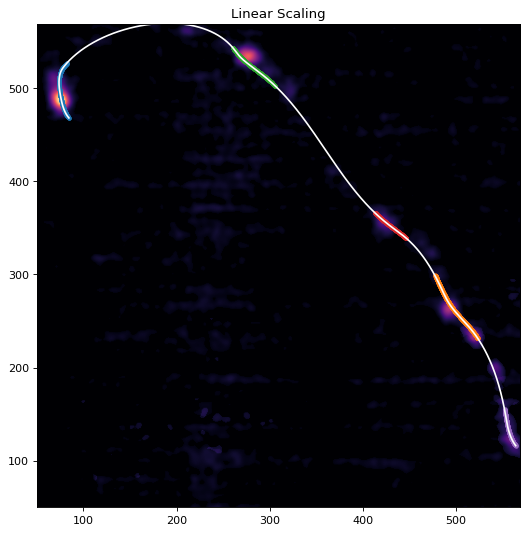

In [ ]:
Ridges=get_ridge(Image,
            sigma = 25,
            lthresh = 0.045, 
            uthresh = 0.0,
            minlen = 20,
            logim = True,
            linkthresh = 1000)

In the above image, the colored lines overlaying the image correspond to the individual ridges that were found for this track. The thin white line corresponds to the final ridge that results after linking all of the smaller ridges together. 

In [ ]:
## Take a look at the output from the above function. You'll notice that for each ridge found (if you used the
## original parameters, there'll only be one), the corresponding column (labelled with an integer) contains 
## each x,y point of the ridge.

Ridges.head()

,0
0,"468.1566617371695,84.3817280280371"
1,"468.6870963664808,83.92294396912413"
2,"469.2316520369958,83.48111839488536"
3,"469.7896525964988,83.05575184159453"
4,"470.36042189277373,82.64634484552529"


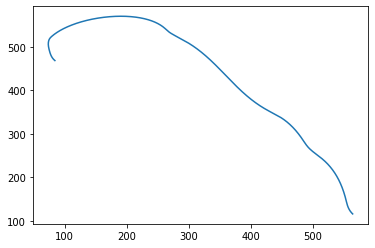

In [ ]:
## We can extract this ridge into something useable
xx = [float(i.split(',')[0]) for i in Ridges['0']] #Grab the x coordinates
yy = [float(i.split(',')[1]) for i in Ridges['0']] #Grab the y coordinates

plt.plot(yy,xx) ## Sanity check that it's extracting correctly. Notice that x and y are flipped

We can also use this to create a bragg curve along the track. For this, we'll actually pull some functions from the RFFunctions python file which was uploaded earlier.   

The function is called InitialBragg and it takes as input:  
**x**: *list* x coordinates of Ridgeline
**y**: *list* y coordinates of Ridgeline
**image**: *numpy array* the image with the track
**d**: *int* the width we're integrating over (pix); default is 5
**show**: *boolean* whether or not you want to visualize the Bragg curve; default is False

The way this function works is that it takes an image and the coordinates of thie ridgeline found for a given track and then it integrates along a line perpendicular to the ridge to get the energy deposition at that point, as shown below. 

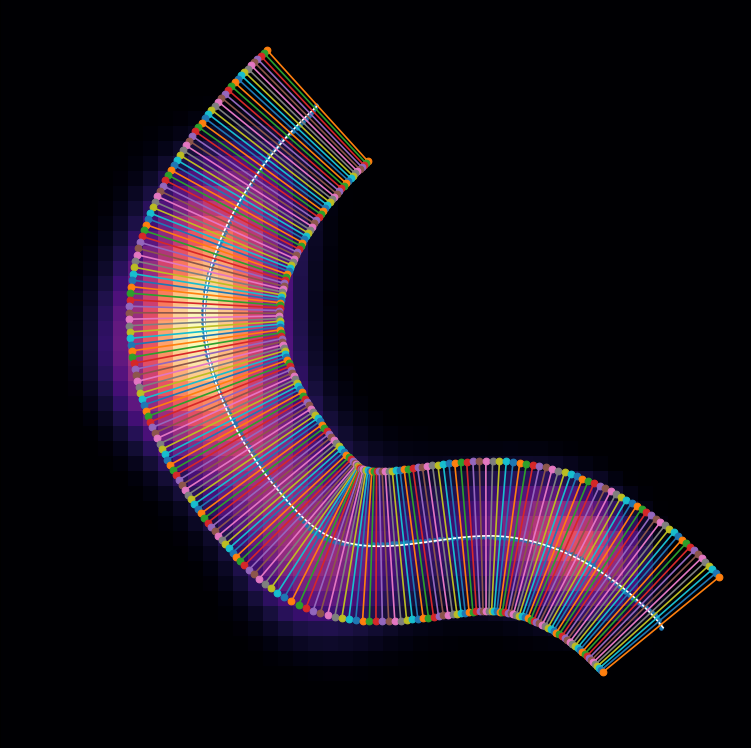

In [ ]:
Bragg = RF.InitialBragg(yy,xx,Image,d=20)

Text(0.5, 1.0, 'Bragg Curve')

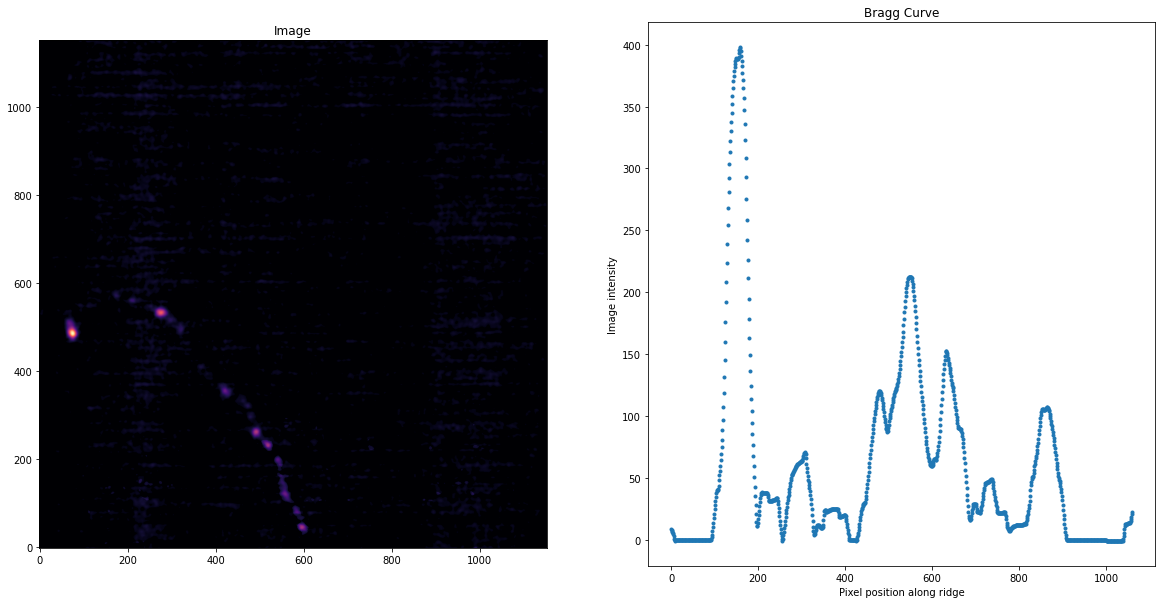

In [ ]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(Image,cmap='magma',origin='lower') ##Note: here we're using the masked, summed image without the Fe-55s, so some noise is included
ax1.set_title("Image")
ax2.plot(Bragg,'.')
ax2.set_xlabel('Pixel position along ridge')
ax2.set_ylabel("Image intensity")
ax2.set_title("Bragg Curve")

## 3D Reconstruction

There are two ways that we will be exploring for 3d track reconstruction. The first will be to turn the raw data into voxels. The second will be using the ridgeline found to reconstruct the track's path as best as we can. 

#### Using the Ridgeline

We use our ridgeline from earlier to get a different 3d representation of the track. If we are only interested in the center of the track then can look for the highest point in each ITO waveform, using the time of this point to get a relative z coordinate. Reminder of the whole process below:

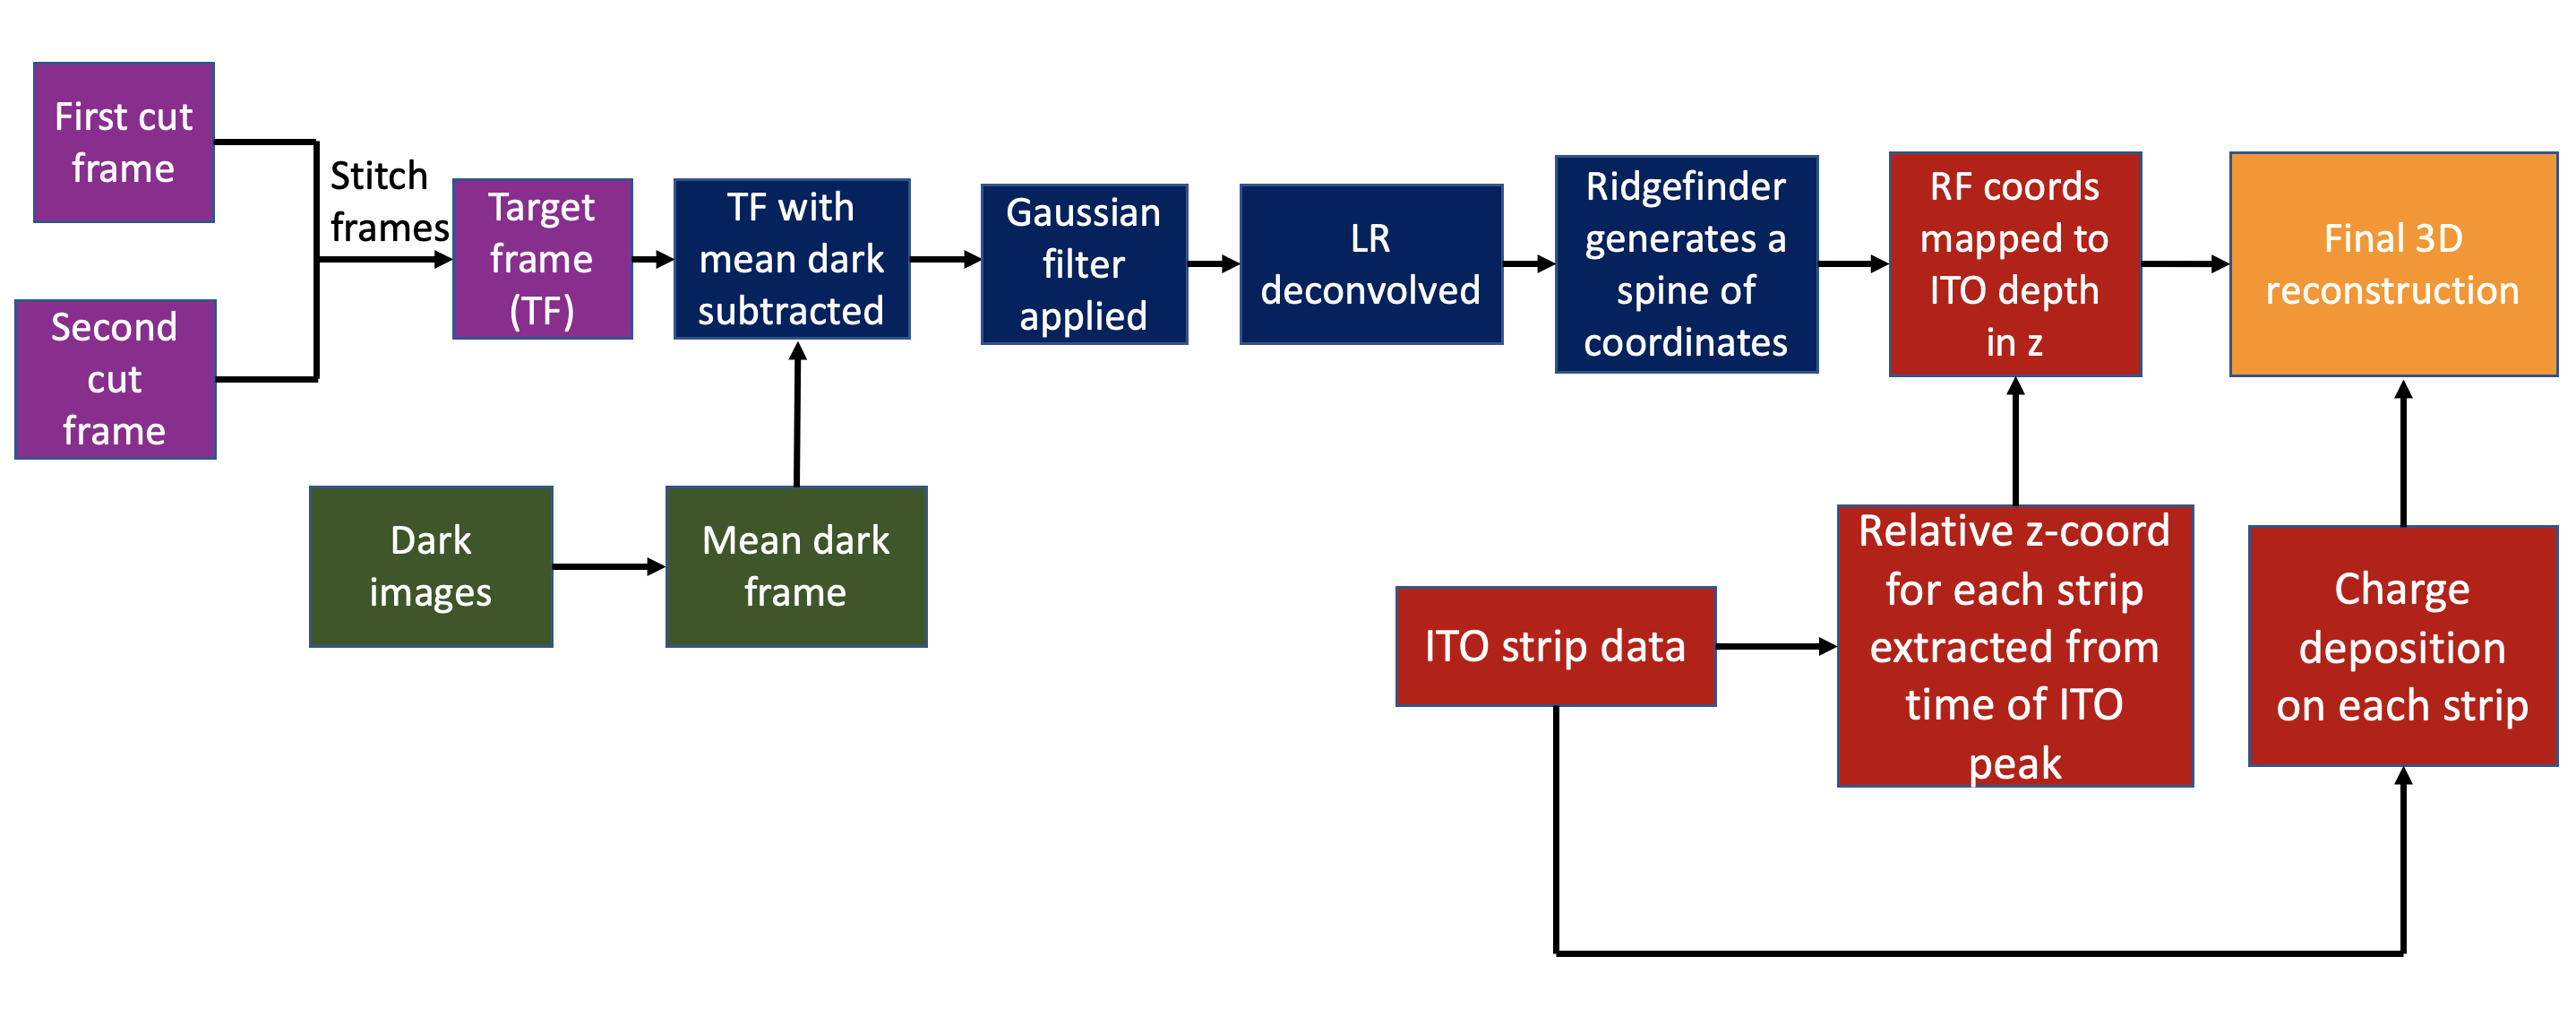

Functions to find the time (in microseconds) of the peak of the ITO waveform, and to convert coordinates in pixels into strips.

In [ ]:
! git clone https://github.com/magnushandley/MIGDAL3dreconstruction.git
! git pull

Cloning into 'MIGDAL3dreconstruction'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
def peaktime(eventdata):
        """
        Returns the sample number at which each ITO strip is at a maximum
        """
        maximums = np.zeros(60)
        maxtimes = np.zeros(60)
        
        for i in range(60):
            max = np.amax(eventdata[i][1])
            maximums[i] = max
            index = int(np.where(eventdata[i][1] == max)[0][0])
            maxtimes[i] = eventdata[i][0][index]
            
        return(maxtimes)

def pixeltostrip(pixel, offset):
    """
    Takes the x coordinates of all points along the ridge and returns the coordinates in strips
    """
    strip = np.add(0.084375*pixel, (10.89996 - offset))
    return(strip)



The x and y coordinates returned from the ridgefinder and flipped from the image ones, so here we flip them back. This matters more here because we're using the ridge as the x and y coordinates for our reconstruction.

In [ ]:
offset = 3
driftvel = 13

y = np.array(xx)
x = np.array(yy)

#taking every ::nth value, the splicing from the ridgefinder gives an almost continuous curve,
#this kind of granularity isn't really required for what we're doing here.
x = x[::5]
y = y[::5]

trackstrip = pixeltostrip(x,offset)

eventdata = np.load("/content/MIGDAL3dreconstruction/CF4_2221_3055.npy")

peaks = np.zeros(120)
halfpeaks = peaktime(eventdata)
peaks[:60] = halfpeaks
peaks[60:] = halfpeaks

stripdep = np.zeros(120)

#we already calculated the charge deposited to each strip earlier
stripdep[:60] = charge
stripdep[60:] = charge
stripdepinterp = interpolate.interp1d(np.arange(120),stripdep)
deposition = stripdepinterp(trackstrip)
        
interpolatedpeaks = interpolate.interp1d(np.arange(120), peaks)

deltaz = np.zeros(len(x))

for i in range(len(trackstrip)):
    deltaz[i] = interpolatedpeaks(trackstrip[i])*driftvel




...And finally we plot the track!

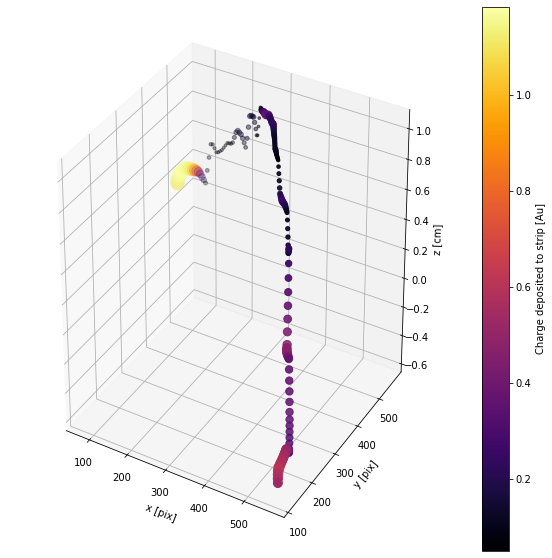

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
scatter_plot = ax.scatter3D(x,y,deltaz,c=deposition,s=deposition*150,cmap='inferno')

ax.set_xlabel("x [pix]")
ax.set_ylabel("y [pix]")
ax.set_zlabel("z [cm]")
#ax.set_zlim(-0.8,-0.4)
#ax.set_xlim(220,320)
#ax.set_ylim(540,600)

plt.colorbar(scatter_plot, label="Charge deposited to strip [Au]")
plt.show()

#### Creating a Voxelized Reconstruction

Now that we have a masked track in both the image and the ITO, we'll do a sort of 'tensor multiplication' to get a voxelized 3d representation of the track. The process is shown graphically below.

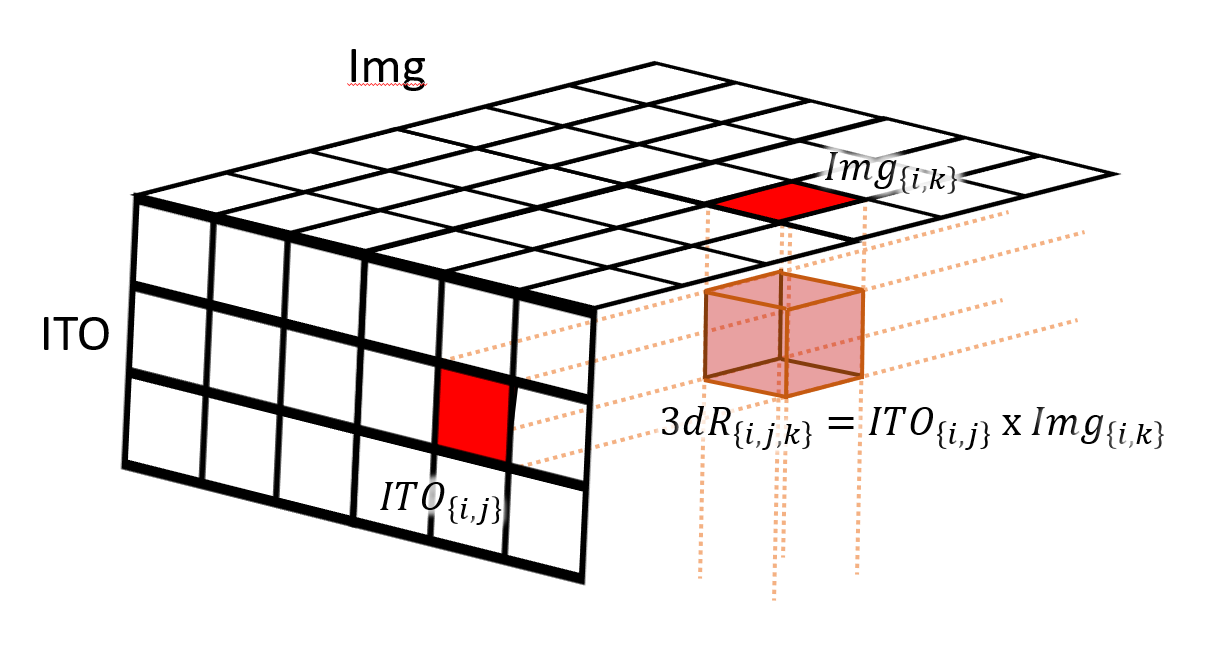

The ITO and the image don't quite line up with one another. The ITO image is a) much smaller and b) covers more physical space. In order to complete this operation, we have to make sure that they're scaled the same and lined up with one another.  

There are two ways to accomplish the first task: 
1. We scale the ITO up to match the pixel scale of the image
2. We scale down the image to match the ITO pixel scale

For now, because it's easier, we'll go with option 2, but in the future, option 1 is better because information isn't lost in downscaling the image. 

Important numbers for scaling (which I pulled from the paper):  
ITO pitch 833 um --> ~ 12 strips/cm (120 strips over 10 cm)  
GEM --> ~ 144 pix/cm (FOV: 8cm x 8cm <=> 1152pix x 1152pix)  
~12 image pix/ITO strip  

Thus, we'll bin our image 12x12.

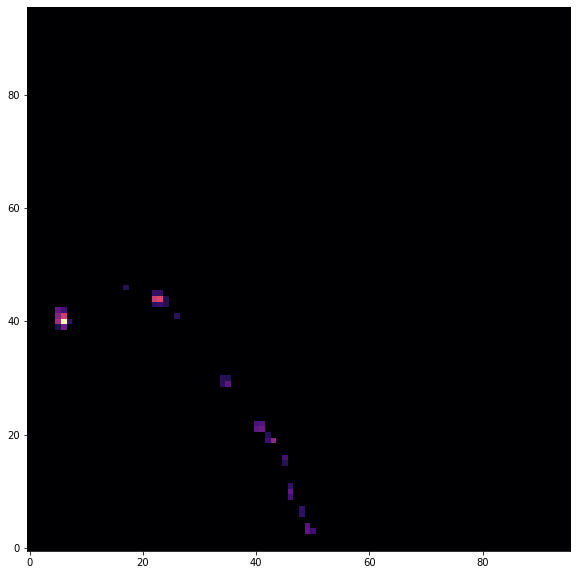

In [ ]:
## Here we bin/rescale the image
n = 12
b = Image.shape[0]//n
ImgBin1 = Image.reshape(-1, n, b, n).sum((-1, -3)) / n ## Our binned image

## Remask the image now that it's been binned since we now really care about the track
img_med = np.median(ImgBin1)
img_sig = np.std(ImgBin1)
thresh = img_med+5*img_sig

ImgBin = (ImgBin1>thresh)*ImgBin1

fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(ImgBin,cmap='magma',origin='lower')

Now, we must make sure that they line up with one another. We can do this by using the x projected bragg curves. This is pretty easy to actually do. 

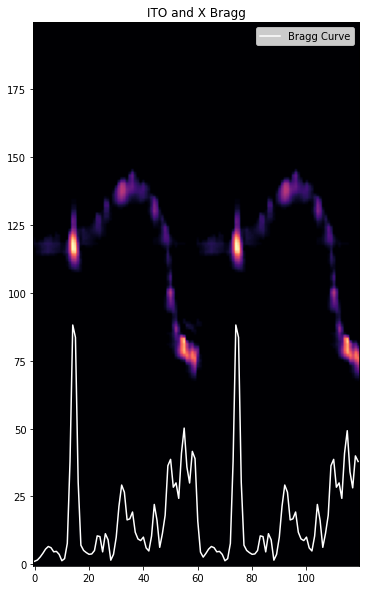

In [ ]:
ITO_xBragg = np.sum(ITOtrack,axis=0) # Project the masked ITO onto the x axis

## Display it to make sure it matches expectation
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(ITOtrack[400:600],cmap='magma',origin='lower')
ax.set_title("ITO and X Bragg")
ax.plot([i*80 for i in ITO_xBragg],color='white',label="Bragg Curve")
plt.legend()
plt.show()

Now, we'll want to look at our now rescaled image.

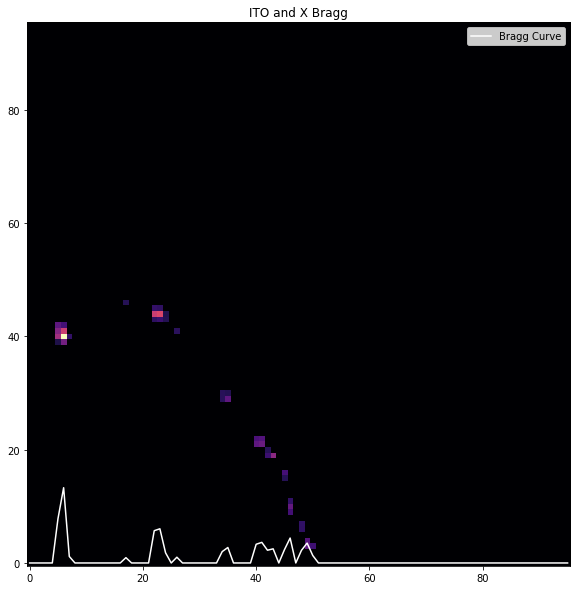

In [ ]:
Img_xBragg = np.sum(ImgBin,axis=0) # Project the masked ITO onto the x axis

## Display it to make sure it matches expectation
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(ImgBin,cmap='magma',origin='lower')
ax.set_title("ITO and X Bragg")
ax.plot([i*0.01 for i in Img_xBragg],color='white',label="Bragg Curve")
plt.legend()
plt.show()

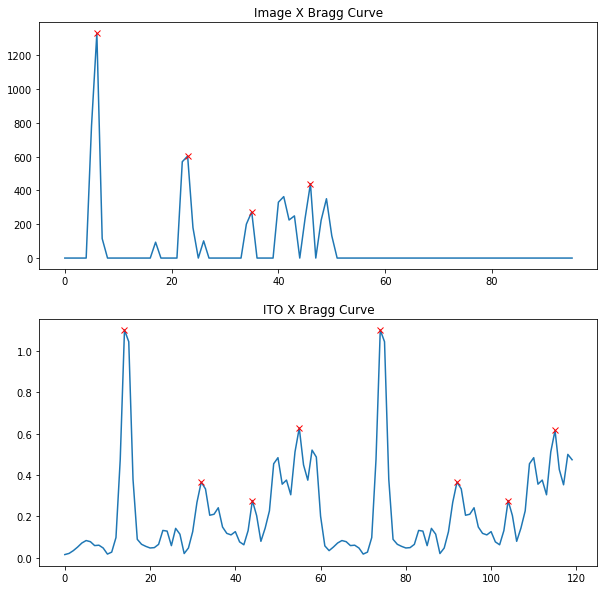

In [ ]:
## Find the shift using the peaks of the Bragg curve
from scipy.signal import find_peaks

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
impeaks, _ = find_peaks(Img_xBragg,distance=10) ## Look for the peaks in the bragg curves
ax1.plot(Img_xBragg,'-')
ax1.plot(impeaks, Img_xBragg[impeaks], "x",color='red')
ax1.set_title("Image X Bragg Curve")
itpeaks, _ = find_peaks(ITO_xBragg,distance=10,height=0.2)
ax2.plot(ITO_xBragg,'-')
ax2.plot(itpeaks, ITO_xBragg[itpeaks], "x",color='red')
ax2.set_title("ITO X Bragg Curve")

plt.show()

Since the two images are scaled the same way, the difference in peak locations between the ITO and the image should correspond to a shift which will line the two up. 

In [ ]:
shift1 = impeaks[0]-itpeaks[0] ## Difference between the first peaks in the image and ITO
shift2 = impeaks[1]-itpeaks[1] ## Difference between the second peaks in the image and ITO
shift3 = impeaks[2]-itpeaks[2] ## Difference between the third peaks in the image and ITO
shift4 = impeaks[3]-itpeaks[3] ## Difference between the fourth peaks in the image and ITO

print("First shift: ",shift1)
print("Second shift: ", shift2)
print("Third shift: ", shift3)
print("Fourth shift: ",shift4)

shift_by=int(abs(np.mean((shift1,shift2,shift3,shift4)))) ## This is the amount we need to shift the image by
print("Averaged shift: ", shift_by)
## We'll "cut" the ITO image to be the same size and shifted by the same amount as the image
ITOcut = ITOtrack[:,shift_by:ImgBin.shape[0]+shift_by] 

## Just as a check
print("Image shape: ", ImgBin.shape)
print("ITO shape: ", ITOcut.shape)

First shift:  -8
Second shift:  -9
Third shift:  -9
Fourth shift:  -9
Averaged shift:  8
Image shape:  (96, 96)
ITO shape:  (990, 96)


In [ ]:
## We have to first initialize the array which will contain the 3d voxelized track 
(itl,itw) = ITOcut.shape
(iml,imw) = ImgBin.shape
event_3d = np.zeros([iml,imw,itl]) #This creates an array that is the length and width of the image and the height of the ito

In [ ]:
## Here, we'll actually do the 'tensor multiplication'

for i in range(iml):
    for j in range(imw):
        for k in range(itl):
            event_3d[i,j,k] = ImgBin[i,j]*ITOcut[k,i]

Now we should have our event voxelized. To visualize this, run the following scripts: 

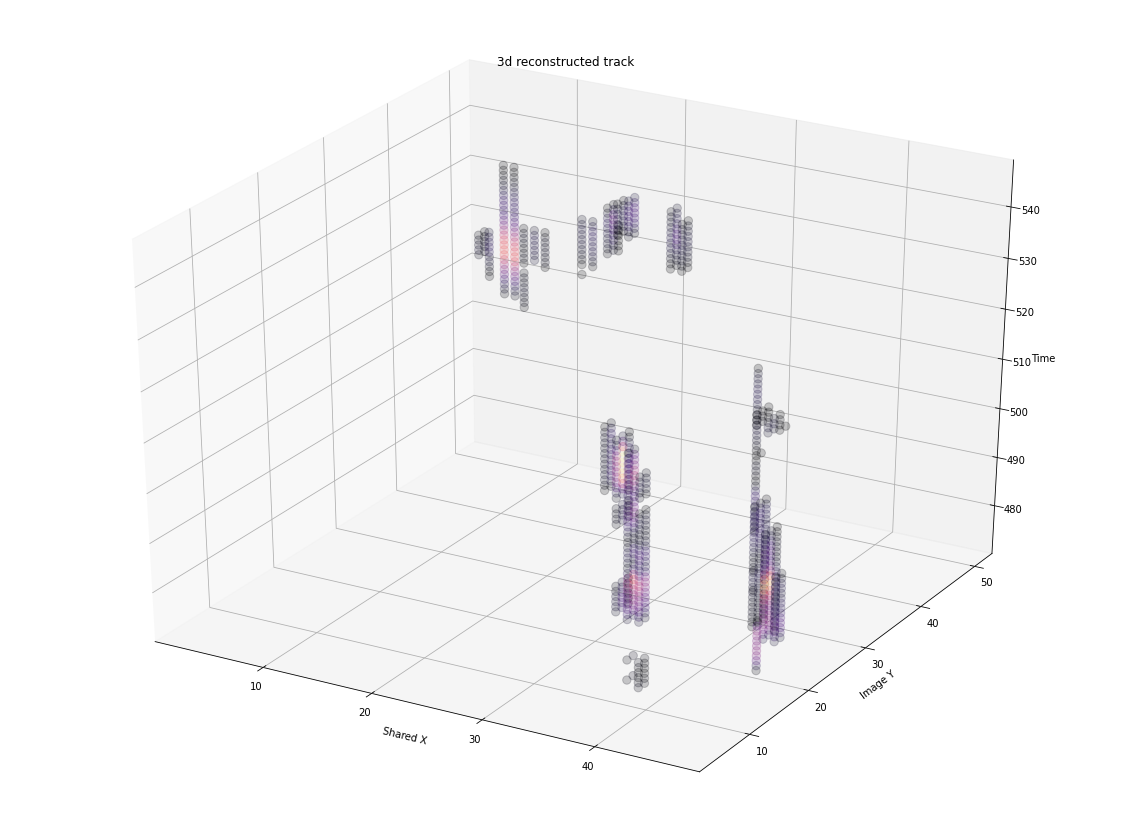

In [ ]:
## This is faster, but it plots the voxelized track as a series of points instead of as voxels
(x,y,z)=event_3d.nonzero() #Find all of the coordinates where the track exists.
I = [event_3d[x[i],y[i],z[i]] for i in range(len(x))] #Get the intensities from each coordinate
#Note: these are relative intensities, not actual energies

ax = plt.figure(figsize=(20,15)).add_subplot(projection='3d')
ax.scatter(x,y,z,'.',c=I,s=70,alpha=0.2,cmap='magma') 
ax.set_title("3d reconstructed track")
ax.set_xlabel("Shared X")
ax.set_ylabel("Image Y")
ax.set_zlabel("Time")

plt.show()

Text(0.5, 0, 'Time')

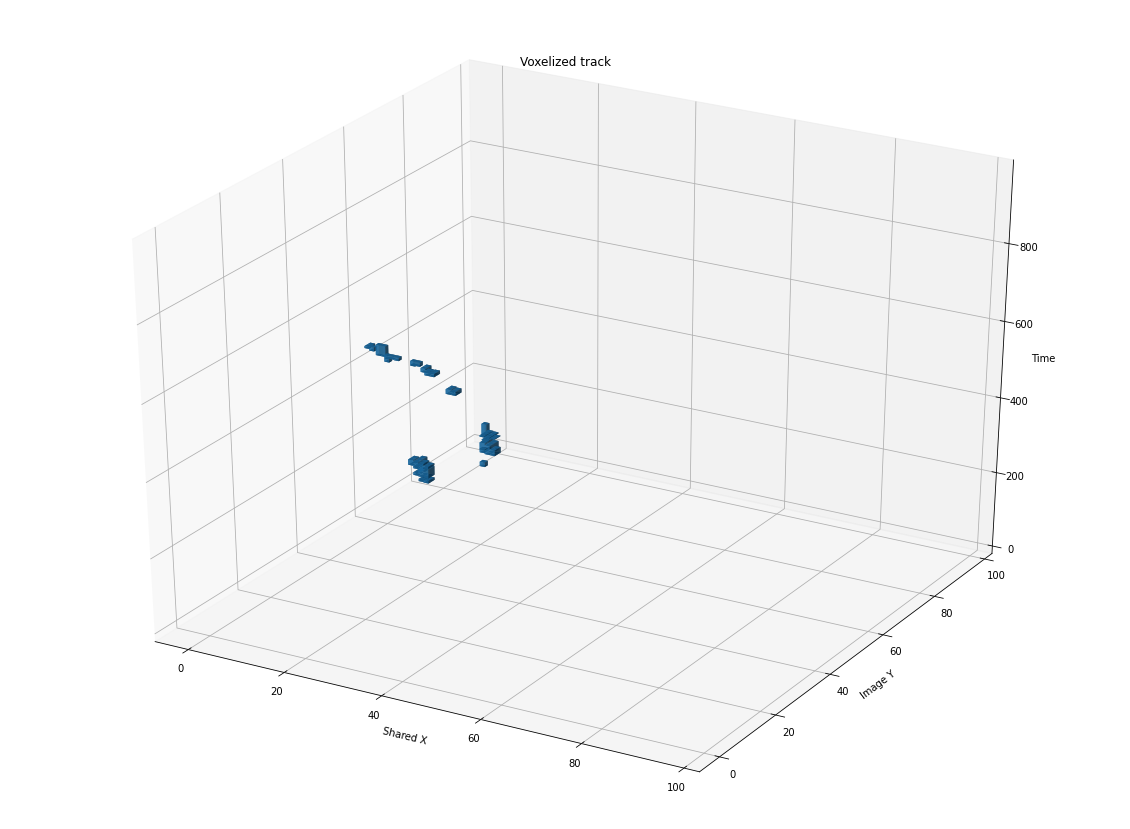

In [ ]:
## This is much slower, but it plots the actual voxels. Note: it currently does not display energy information
ax = plt.figure(figsize=(20,15)).add_subplot(projection='3d')
ax.voxels(event_3d)
ax.set_title("Voxelized track")
ax.set_xlabel("Shared X")
ax.set_ylabel("Image Y")
ax.set_zlabel("Time")